In [84]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.offline as py
import plotly.graph_objs as go

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np

py.init_notebook_mode(connected=True)
%matplotlib inline

In [85]:
import matplotlib.pyplot as plt

data = 'ETH-EUR_11_11_2017-07_12_2022.csv'
dataset = pd.read_csv(data)
chosen_col = 'Close'

In [86]:
print(len(dataset))
dataset.head()

1853


,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-11,256.011322,273.902954,255.673492,269.811371,269.811371,722199256
1,2017-11-12,269.819092,273.739624,255.948730,264.072021,264.072021,1383773530
2,2017-11-13,263.314758,281.949707,263.405121,271.556213,271.556213,893329318
3,2017-11-14,271.596497,290.873871,271.573212,286.394958,286.394958,907354313
4,2017-11-15,286.677399,289.079956,279.644714,282.937531,282.937531,613364441


In [87]:
split_row = len(dataset) - int(0.2 * len(dataset))
train_data = dataset.iloc[:split_row]
test_data = dataset.iloc[split_row:]

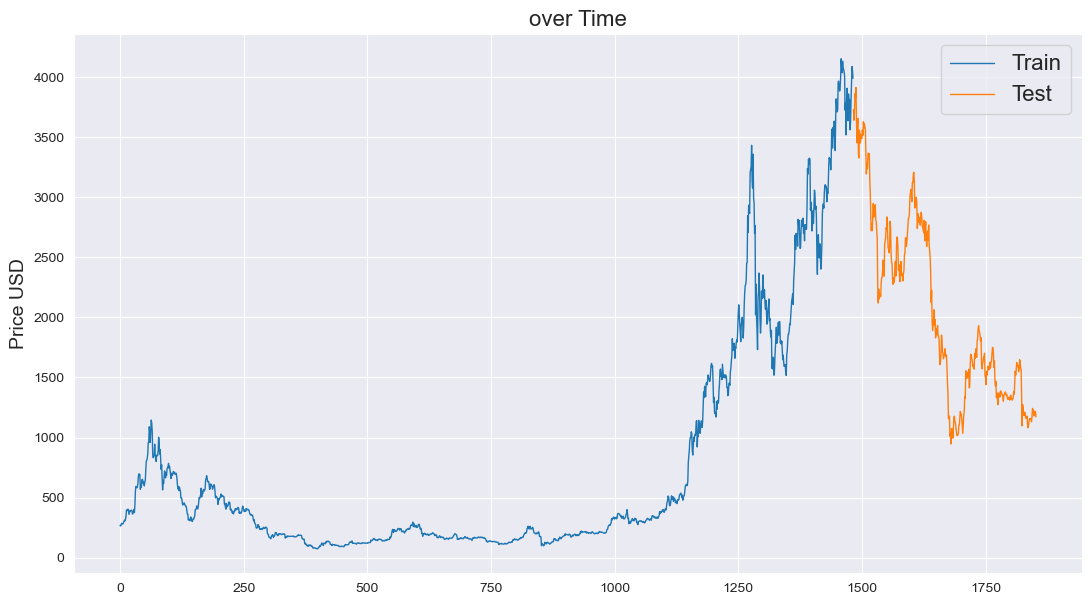

In [88]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(train_data[chosen_col], label='Train', linewidth=1)
ax.plot(test_data[chosen_col], label='Test', linewidth=1)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('over Time', fontsize=16)
ax.legend(loc='best', fontsize=16)

In [89]:
data = pd.read_csv(filepath_or_buffer="ETH-EUR_11_11_2017-07_12_2022.csv", index_col="Date")
btc_trace = go.Scatter(x=data.index, y=data['Open'], name= 'Price')
py.iplot([btc_trace])

In [90]:
from sklearn.preprocessing import MinMaxScaler

datacol = dataset.iloc[:, 5:6].values
traincol = train_data.iloc[:, 5:6].values
testcol = test_data.iloc[:, 5:6].values

shaped_data = np.reshape(datacol, (-1,1))
train_shaped = np.reshape(traincol, (-1,1))
test_shaped = np.reshape(testcol, (-1,1))

sc = MinMaxScaler(feature_range=(0,1))
sc.fit(shaped_data)

train_scaled_data = sc.transform(train_shaped)
test_scaled_data = sc.transform(test_shaped)

In [91]:
X = []
y = []
time_steps = 50

for i in range(time_steps, len(train_data)):
    X.append(train_scaled_data[i-time_steps:i,0])
    y.append(train_scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [92]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [93]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation

model = Sequential()
model.add(LSTM(units=100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(optimizer='adam', loss='mse')

In [94]:
from keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=1, callbacks=[callback], shuffle=True)

Epoch 1/100
36/36 [==============================] - 1s 22ms/step - loss: 0.0114 - val_loss: 0.0019
Epoch 2/100
36/36 [==============================] - 0s 13ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 3/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 4/100
36/36 [==============================] - 0s 14ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 5/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0013 - val_loss: 7.7664e-04
Epoch 6/100
36/36 [==============================] - 0s 13ms/step - loss: 9.9439e-04 - val_loss: 6.9266e-04
Epoch 7/100
36/36 [==============================] - 0s 13ms/step - loss: 0.0010 - val_loss: 6.6530e-04
Epoch 8/100
36/36 [==============================] - 0s 13ms/step - loss: 0.0010 - val_loss: 7.0290e-04
Epoch 9/100
36/36 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 8.4310e-04
Epoch 10/100
36/36 [==============================] - 0s 13ms/step - loss: 0

In [95]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [96]:
from keras.metrics import mean_absolute_error

X_testing = []
y_testing = []

for i in range(time_steps, len(test_data)):
    X_testing.append(test_scaled_data[i-time_steps:i,0])
    y_testing.append(test_scaled_data[i, 0])

X_testing, y_testing = np.array(X_testing), np.array(y_testing)
X_testing = np.reshape(X_testing, (X_testing.shape[0], X_testing.shape[1], 1))

predicted_price = model.predict(X_testing)
inv_price = sc.inverse_transform(predicted_price)
real_price = np.reshape(y_testing, (-1,1))
real_price = sc.inverse_transform(real_price)

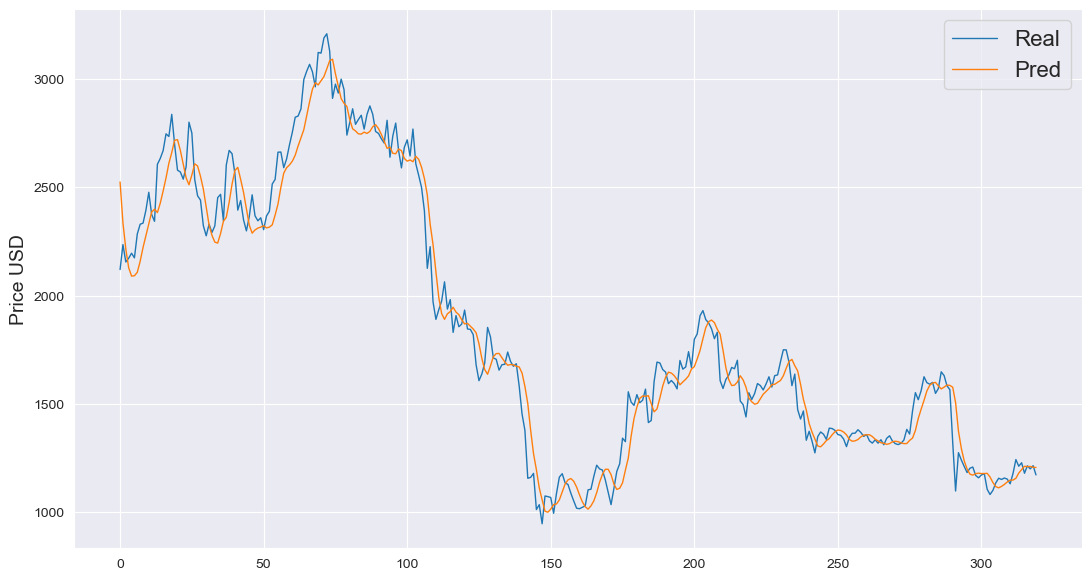

In [98]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(real_price, label='Real', linewidth=1)
ax.plot(inv_price, label='Pred', linewidth=1)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)